# Explore simulated relationship

This notebook is using simulated data generated from [main_Pa_sim_enhance_AtoB](main_Pa_sim_enhance_AtoB.ipynb).  This notebook input raw Pseudomonas gene expression data from the Pseudomonas compendium referenced in [ADAGE](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5069748/) paper and added a strong nonlinear signal.  This signal assigned a set of genes to group A and a set of genes to group B.  If the expression of genes in group A exceeded some threshold then the genes in group B were upregulated.  

This notebook is tryign to determine if our VAE model is able to detect the relationship between A and B (i.e. when the expression of genes in set A exceed some threshold then the genes in set B are upregulated).


In [2]:
%load_ext autoreload
%autoreload 2

import os
import pandas as pd
import numpy as np
import random
import glob
import seaborn as sns
from keras.models import model_from_json, load_model
from functions import utils
import matplotlib.pyplot as plt
from matplotlib_venn import venn2

from numpy.random import seed
randomState = 123
seed(randomState)

Using TensorFlow backend.


In [2]:
# Run notebook to generate simulated data
#%run ./main_Pa_sim_enhance_AtoB.ipynb

In [3]:
# Load 
base_dir = os.path.dirname(os.getcwd())
analysis_name = 'sim_AB_2775_300_v2'

sim_data_file = os.path.join(base_dir, "data", analysis_name, "train_model_input.txt.xz")
A_file = os.path.join(base_dir, "data", analysis_name, "geneSetA.txt")
B_file = os.path.join(base_dir, "data", analysis_name, "geneSetB.txt")

offset_vae_file = os.path.join(os.path.dirname(os.getcwd()), "encoded", analysis_name, "offset_latent_space_vae.txt")

weight_file = os.path.join(os.path.dirname(os.getcwd()), "data", analysis_name, "VAE_weight_matrix.txt")

model_encoder_file = glob.glob(os.path.join(base_dir, "models", analysis_name, "*_encoder_model.h5"))[0]
weights_encoder_file = glob.glob(os.path.join(base_dir, "models", analysis_name, "*_encoder_weights.h5"))[0]
model_decoder_file = glob.glob(os.path.join(base_dir, "models", analysis_name, "*_decoder_model.h5"))[0]
weights_decoder_file = glob.glob(os.path.join(base_dir, "models", analysis_name, "*_decoder_weights.h5"))[0]

In [4]:
# Read data
sim_data = pd.read_table(sim_data_file, index_col=0, header=0, compression='xz')
geneSetA = pd.read_table(A_file, header=0, index_col=0)
geneSetB = pd.read_table(B_file, header=0, index_col=0)

print(sim_data.shape)
sim_data.head()

(1191, 5549)


,PA0001,PA0002,PA0003,PA0004,PA0005,PA0006,PA0007,PA0008,PA0009,PA0010,...,PA5561,PA5562,PA5563,PA5564,PA5565,PA5566,PA5567,PA5568,PA5569,PA5570
0.1_12hr_CSV86(Pae_G1a).CEL,0.47290,0.39666,0.25378,0.000000,0.17564,0.55439,0.41137,0.382220,0.31014,0.64252,...,0.35860,0.39005,0.457410,0.68408,0.33835,0.60832,0.64350,0.27607,0.112770,0.14517
0.1_2hr_CSV86(Pae_G1a).CEL,0.26235,0.12932,0.53978,0.439210,0.26975,0.76843,0.21250,0.062043,0.56769,0.70061,...,0.35850,0.41421,0.389880,0.47769,0.00000,0.47939,0.15447,0.14089,0.167510,0.15706
0.1_6hr_CSV86(Pae_G1a).CEL,0.47366,0.24486,0.33075,0.097697,0.38723,0.32832,0.22882,0.330040,0.31808,0.51286,...,0.18074,0.38074,0.173500,0.25157,0.18279,0.52830,0.50498,0.49978,0.061106,0.36561
0.1_7hr_CSV86(Pae_G1a).CEL,0.43927,0.51510,0.28905,0.274680,0.62898,0.55380,0.43139,0.363480,0.38572,0.14188,...,0.34684,0.15393,0.067349,0.31972,0.28244,0.49066,0.53141,0.15388,0.132330,0.26009
0.1_9hr_CSV86(Pae_G1a).CEL,0.22083,0.21829,0.65670,0.293200,0.63512,0.46289,0.48873,0.309580,0.31865,0.88787,...,0.23773,0.30194,0.070222,0.51360,0.11428,0.36026,0.38687,0.22400,0.105340,0.10209


In [14]:
# Select samples that have expression of gene A around the threshold 
# Since threshold is 0.5 then select samples with expression in range(0.4, 0.6)

# Since our simulation set all genes in set A to be the same value for a give sample
# we can consider a single gene in set A to query by
rep_gene_A = geneSetA.iloc[0][0]

# Query for samples whose representative gene A expression is in range (0.4, 0.6)
#test_samples = sim_data.query('0.4 < @rep_gene_A < 0.6') -- why didn't this work?
test_samples = sim_data[(sim_data[rep_gene_A]>0.4) & (sim_data[rep_gene_A]<0.6)]

test_samples_sorted = test_samples.sort_values(by=[rep_gene_A])

print(test_samples_sorted.shape)
test_samples_sorted.head()

(250, 5549)


,PA0001,PA0002,PA0003,PA0004,PA0005,PA0006,PA0007,PA0008,PA0009,PA0010,...,PA5561,PA5562,PA5563,PA5564,PA5565,PA5566,PA5567,PA5568,PA5569,PA5570
GSM597217.CEL,0.35460,0.48779,0.46557,0.40792,0.37706,0.13863,0.099159,0.26799,0.24812,0.23688,...,0.45332,0.65551,0.60552,0.49703,0.55529,0.40825,0.60875,0.29440,0.53128,0.62551
Van_Delden_Kohler_0311_PT5_3.CEL,0.55113,0.78432,0.47270,0.71525,0.50413,0.60012,0.385300,0.39754,0.32814,0.18864,...,0.28174,0.47880,0.55367,0.41051,0.38984,0.21070,0.35172,0.31529,0.55191,0.48838
GSM567695.CEL,0.48018,0.33651,0.53276,0.45889,0.31316,0.69730,0.325200,0.32220,0.34808,0.24138,...,0.77773,0.25464,0.54541,0.66889,0.76181,0.24066,0.11548,0.34214,0.81677,0.91436
GSM617289.CEL,0.64608,0.66750,0.31669,0.72586,0.32237,0.31344,0.244170,0.62315,0.48616,0.24528,...,0.40715,0.66434,0.60865,0.64910,0.70492,0.43934,0.52772,0.60611,0.72526,0.63749
GSM546274.CEL,0.80436,0.74999,0.62517,0.74950,0.68386,0.53361,0.093537,0.73341,0.77629,0.17730,...,0.53164,0.73539,0.83640,0.78667,0.82217,0.26913,0.60590,0.67231,0.78787,0.82318


## Trend of gene B with respect to A (before transformation)

How is B changing with respect to A in our simulated dataset?

Plot gene expression of A vs mean(gene B expression).  This plot will serve as a reference against the later plot that will show gene expression of A vs mean(**transformed** gene B expression)

In [15]:
# Get the means of B genes

# Convert dataframe with gene ids to list
geneSetB_ls = geneSetB['gene id'].values.tolist()

geneSetB_exp = test_samples[geneSetB_ls]

# Get the mean for each sample
geneSetB_mean = geneSetB_exp.mean(axis=1)
geneSetB_mean.head()

0.1_12hr_CSV86(Pae_G1a).CEL    0.368401
143b_2014wt_anaero.CEL         0.554085
147_2014dR_anaero.CEL          0.558296
aerobic_NO3_2.CEL              0.622169
anaerobic_NO3_2.CEL            0.400427
dtype: float64

In [7]:
# Join original expression of A and mean(transformed expression of B)
original_A_exp = test_samples[rep_gene_A]
original_B_mean_exp = geneSetB_mean

A_and_B_before_df = pd.merge(original_A_exp.to_frame('gene A untransformed'),
                      original_B_mean_exp.to_frame('mean gene B untransformed'),
                      left_index=True, right_index=True)
A_and_B_before_df.head()

,gene A untransformed,mean gene B untransformed
0.1_12hr_CSV86(Pae_G1a).CEL,0.41774,0.368401
143b_2014wt_anaero.CEL,0.53344,0.554085
147_2014dR_anaero.CEL,0.59164,0.558296
aerobic_NO3_2.CEL,0.58456,0.622169
anaerobic_NO3_2.CEL,0.44310,0.400427


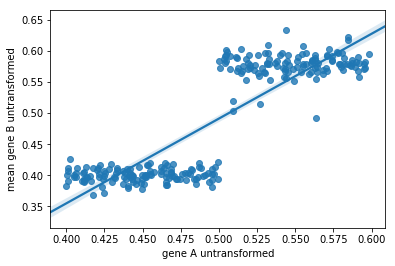

In [8]:
# Plot
sns.regplot(x='gene A untransformed',
            y='mean gene B untransformed',
           data = A_and_B_before_df)

## Trend of gene B with respect to A (after transformation)

How is B changing with respect to A after applying our latent space transformation?

In [9]:
# Define function to apply latent space transformation and output reconstructed data

def interpolate_in_vae_latent_space_AB(all_data, 
                                       sample_data,
                                       model_encoder_file,
                                       model_decoder_file,
                                       weights_encoder_file,
                                       weights_decoder_file,
                                       encoded_dir,
                                       gene_id,
                                       percent_low,
                                       percent_high,
                                       out_dir):
    """
    interpolate_in_vae_latent_space(all_data: dataframe,
                                    sample_data: dataframe,
                                    model_encoder_file: string,
                                    model_decoder_file: string,
                                    weights_encoder_file: string,
                                    weights_decoder_file: string,
                                    encoded_dir: string,
                                    gene_id: string,
                                    percent_low: integer,
                                    percent_high: integer,
                                    out_dir: string):

    input:
        all_data: Dataframe with gene expression data from all samples
        
        sample_data:  Dataframe with gene expression data from subset of samples (around the treshold)

        model_encoder_file: file containing the learned vae encoder model

        model_decoder_file: file containing the learned vae decoder model
        
        weights_encoder_file: file containing the learned weights associated with the vae encoder model
        
        weights_decoder_file: file containing the learned weights associated with the vae decoder model
        
        encoded_dir:  directory to use to output offset vector to 

        gene_id: gene you are using as the "phenotype" to sort samples by 

                 This gene is referred to as "target_gene" in comments below


        percent_low: integer between 0 and 1

        percent_high: integer between 0 and 1
        
        out_dir: directory to output predicted gene expression to

    computation:
        1.  Sort samples based on the expression level of the target gene defined by the user
        2.  Sample_data are encoded into VAE latent space
        3.  We predict the expression profile of the OTHER genes at a given level of target gene 
            expression by adding a scale factor of offset vector to the sample

            The scale factor depends on the distance along the target gene expression gradient
            the sample is.  For example the range along the target gene expression is from 0 to 1.  
            If the sample of interest has a target gene expression of 0.3 then our prediction
            for the gene expression of all other genes is equal to the gene expression corresponding
            to the target gene expression=0 + 0.3*offset latent vector
        3.  Prediction is decoded back into gene space
        4.  This computation is repeated for all samples 

    output: 
         1. encoded predicted expression profile per sample
         2. predicted expression profile per sample

    """

    # Load arguments
    offset_file = os.path.join(encoded_dir, "offset_latent_space_vae.txt")

    # Output file
    predict_file = os.path.join(out_dir, "predicted_gene_exp.txt")
    predict_encoded_file = os.path.join(out_dir, "predicted_encoded_gene_exp.txt")

    # Read in data
    target_gene_data = all_data[gene_id]
    offset_encoded = pd.read_table(offset_file, header=0, index_col=0)    
    
    # read in saved VAE models
    loaded_model = load_model(model_encoder_file)
    loaded_decoder_model = load_model(model_decoder_file)

    # load weights into models
    loaded_model.load_weights(weights_encoder_file)
    loaded_decoder_model.load_weights(weights_decoder_file)
    
    # Sort target gene data by expression (lowest --> highest)
    target_gene_sorted = target_gene_data.sort_values()

    lowest_file = os.path.join(encoded_dir, "lowest_encoded_vae.txt")
    low_exp_encoded = pd.read_table(lowest_file, header=0, index_col=0)
    
    # Average gene expression across samples in each extreme group
    lowest_mean_encoded = low_exp_encoded.mean(axis=0)

    # Format and rename as "baseline"
    baseline_encoded = pd.DataFrame(
        lowest_mean_encoded, index=offset_encoded.columns).T
    
    # Initialize dataframe for predicted expression of sampled data
    predicted_sample_data = pd.DataFrame(columns=sample_data.columns)
    predicted_encoded_sample_data = pd.DataFrame()
    
    sample_ids = sample_data.index
    for sample_id in sample_ids:
        intermediate_target_gene_exp = target_gene_sorted[sample_id]
        print('gene A exp is {}'.format(intermediate_target_gene_exp))
        alpha = get_scale_factor(
            target_gene_sorted, intermediate_target_gene_exp, percent_low, percent_high)
        print('scale factor is {}'.format(alpha))
        predict = baseline_encoded + alpha * offset_encoded

        predict_encoded_df = pd.DataFrame(predict)
        predicted_encoded_sample_data = predicted_encoded_sample_data.append(predict_encoded_df, ignore_index=True)
        
        # Decode prediction
        predict_decoded = loaded_decoder_model.predict_on_batch(predict)
        predict_df = pd.DataFrame(
            predict_decoded, columns=sample_data.columns)
        predicted_sample_data = predicted_sample_data.append(predict_df, ignore_index=True)

    predicted_sample_data.set_index(sample_data.index, inplace=True)
    predicted_encoded_sample_data.set_index(sample_data.index, inplace=True)
    
    # Output estimated gene experession values
    predicted_sample_data.to_csv(predict_file, sep='\t')
    predicted_encoded_sample_data.to_csv(predict_encoded_file, sep='\t')
    
def get_scale_factor(target_gene_sorted, expression_profile,
                     percent_low, percent_high):
    """
    get_scale_factor(target_gene_sorted: dataframe,
                    expression_profile: dataframe,
                    percent_low: integer,
                    percent_high: integer,):

    input:
        target_gene_sorted: dataframe of sorted target gene expression

        expression_profile: dataframe of gene expression for selected sample

        percent_low: integer between 0 and 1

        percent_high: integer between 0 and 1

    computation:
        Determine how much to scale offset based on distance along the target gene expression gradient

    Output:
     scale factor = intermediate gene expression/ (average high target gene expression - avgerage low target gene expression) 
    """

    # Collect the extreme gene expressions
    # Get sample IDs with the lowest 5% of reference gene expression
    threshold_low = np.percentile(target_gene_sorted, percent_low)
    lowest = target_gene_sorted[target_gene_sorted <= threshold_low]

    # Get sample IDs with the highest 5% of reference gene expression
    threshold_high = np.percentile(target_gene_sorted, percent_high)
    highest = target_gene_sorted[target_gene_sorted >= threshold_high]

    # Average gene expression across samples in each extreme group
    lowest_mean = (lowest.values).mean()
    highest_mean = (highest.values).mean()

    # Different in extremes
    denom = highest_mean - lowest_mean

    # scale_factor is the proportion along the gene expression gradient
    scale_factor = expression_profile / denom

    return scale_factor

In [10]:
# Apply function 
out_dir = os.path.join(base_dir, "output", analysis_name)
encoded_dir = os.path.join(base_dir, "encoded", analysis_name)

percent_low = 5
percent_high = 95
interpolate_in_vae_latent_space_AB(sim_data,
                                   test_samples_sorted,
                                   model_encoder_file,
                                   model_decoder_file,
                                   weights_encoder_file,
                                   weights_decoder_file,
                                   encoded_dir,
                                   rep_gene_A,
                                   percent_low,
                                   percent_high,
                                   out_dir)

/home/alexandra/anaconda3/envs/Pa/lib/python3.5/site-packages/keras/models.py:255: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


gene A exp is 0.40005
scale factor is 0.4253390017674791
gene A exp is 0.40023000000000003
scale factor is 0.4255303803959459
gene A exp is 0.40085
scale factor is 0.4261895734495537
gene A exp is 0.4012
scale factor is 0.42656169856046144
gene A exp is 0.40137
scale factor is 0.4267424450429023
gene A exp is 0.40225
scale factor is 0.42767807389318446
gene A exp is 0.40501
scale factor is 0.43061254619634215
gene A exp is 0.40526
scale factor is 0.4308783498469905
gene A exp is 0.40628000000000003
scale factor is 0.43196282874163583
gene A exp is 0.40631999999999996
scale factor is 0.43200535732573947
gene A exp is 0.40684000000000003
scale factor is 0.43255822891908813
gene A exp is 0.41038
scale factor is 0.4363220086122686
gene A exp is 0.41115
scale factor is 0.43714068385626553
gene A exp is 0.41128000000000003
scale factor is 0.43727890175460266
gene A exp is 0.41145
scale factor is 0.4374596482370435
gene A exp is 0.41161000000000003
scale factor is 0.4376297625734585
gene A ex

scale factor is 0.5518721716221165
gene A exp is 0.51948
scale factor is 0.5523187217552057
gene A exp is 0.5201
scale factor is 0.5529779148088135
gene A exp is 0.52027
scale factor is 0.5531586612912545
gene A exp is 0.52268
scale factor is 0.5557210084835045
gene A exp is 0.52364
scale factor is 0.5567416945019941
gene A exp is 0.52546
scale factor is 0.5586767450787141
gene A exp is 0.5257
scale factor is 0.5589319165833364
gene A exp is 0.5263399999999999
scale factor is 0.5596123739289961
gene A exp is 0.52683
scale factor is 0.5601333490842669
gene A exp is 0.5282100000000001
scale factor is 0.5616005852358459
gene A exp is 0.52941
scale factor is 0.5628764427589579
gene A exp is 0.52987
scale factor is 0.5633655214761507
gene A exp is 0.53042
scale factor is 0.5639502895075772
gene A exp is 0.53133
scale factor is 0.5649178147959371
gene A exp is 0.53166
scale factor is 0.565268675614793
gene A exp is 0.5321199999999999
scale factor is 0.5657577543319858
gene A exp is 0.5324
sc

## Plot
Plot gene expression A vs mean expression of genes in set B after transformation
What is the relationship between genes in set A and B?  As the expression of A varies how does the expression of B vary?

In [11]:
# Read dataframe with gene expression transformed
predict_file = os.path.join(base_dir, "output", analysis_name, "predicted_gene_exp.txt")
predict_gene_exp = pd.read_table(predict_file, header=0, index_col=0)

print(predict_gene_exp.shape)
predict_gene_exp.head()

(250, 5549)


,PA0001,PA0002,PA0003,PA0004,PA0005,PA0006,PA0007,PA0008,PA0009,PA0010,...,PA5561,PA5562,PA5563,PA5564,PA5565,PA5566,PA5567,PA5568,PA5569,PA5570
GSM597217.CEL,0.588698,0.658995,0.507168,0.597505,0.446048,0.440019,0.414234,0.522333,0.511903,0.298343,...,0.435323,0.523467,0.567050,0.574536,0.588685,0.335117,0.511520,0.534952,0.604285,0.573375
Van_Delden_Kohler_0311_PT5_3.CEL,0.588699,0.659056,0.507209,0.597502,0.446041,0.440012,0.414223,0.522334,0.511901,0.298365,...,0.435316,0.523470,0.567053,0.574539,0.588680,0.335120,0.511522,0.534947,0.604283,0.573373
GSM567695.CEL,0.588704,0.659266,0.507353,0.597494,0.446017,0.439988,0.414184,0.522337,0.511896,0.298440,...,0.435294,0.523480,0.567065,0.574549,0.588663,0.335129,0.511529,0.534930,0.604278,0.573366
GSM617289.CEL,0.588707,0.659384,0.507435,0.597489,0.446003,0.439975,0.414162,0.522338,0.511893,0.298482,...,0.435281,0.523485,0.567072,0.574554,0.588654,0.335134,0.511532,0.534921,0.604275,0.573362
GSM546274.CEL,0.588708,0.659442,0.507474,0.597487,0.445996,0.439968,0.414152,0.522339,0.511892,0.298502,...,0.435275,0.523488,0.567076,0.574557,0.588649,0.335136,0.511534,0.534916,0.604273,0.573360


In [12]:
# Get the means of B genes

# Convert dataframe with gene ids to list
geneSetB_ls = geneSetB['gene id'].values.tolist()

geneSetB_exp = predict_gene_exp[geneSetB_ls]

# Get the mean for each sample
geneSetB_mean = geneSetB_exp.mean(axis=1)
geneSetB_mean.head()

GSM597217.CEL                       0.462557
Van_Delden_Kohler_0311_PT5_3.CEL    0.462594
GSM567695.CEL                       0.462722
GSM617289.CEL                       0.462794
GSM546274.CEL                       0.462829
dtype: float64

In [13]:
# Join original expression of A and mean(transformed expression of B)
original_A_exp = test_samples[rep_gene_A]
predict_B_mean_exp = geneSetB_mean

A_and_B_df = pd.merge(original_A_exp.to_frame('gene A untransformed'),
                      predict_B_mean_exp.to_frame('mean gene B transformed'),
                      left_index=True, right_index=True)
A_and_B_df.head()

,gene A untransformed,mean gene B transformed
0.1_12hr_CSV86(Pae_G1a).CEL,0.41774,0.466186
143b_2014wt_anaero.CEL,0.53344,0.489894
147_2014dR_anaero.CEL,0.59164,0.501843
aerobic_NO3_2.CEL,0.58456,0.500366
anaerobic_NO3_2.CEL,0.44310,0.471370


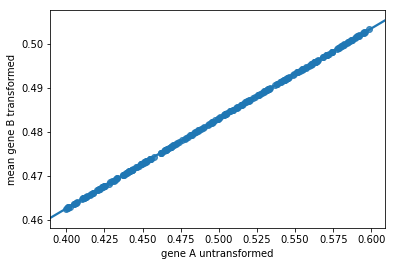

In [14]:
# Plot
sns.regplot(x='gene A untransformed',
            y='mean gene B transformed',
           data = A_and_B_df)

**Observations**:  This plot shows that the relationship that is learned by the VAE appears to be linear, which is NOT the relationship that we put into the dataset (remember we put a step function relationship).  So now the question is why the VAE is learning a linear relationship between A and B genes?  Or is this an artifact of how we plotted the data?

## What is the offset capturing?

How are the values of the latent features changing as A moves across threshold? i.e. What is the difference in the encodings when gene A expression is above vs below the threshold?

This is the shift we should be capturing in our offset vector

Currently we are using the extremes of gene A to capture the “essence of A” and what it means to “turn on”

In [15]:
# Read VAE space offset
offset_vae_space = pd.read_table(offset_vae_file, header=0, index_col=0)
offset_vae_space

,0,1,2,3,4,5,6,7,8,9,...,290,291,292,293,294,295,296,297,298,299
0,0.50522,0.5764,-2.2113,-0.42799,0.049305,-0.53306,0.000179,-0.18614,-0.6475,0.73362,...,-0.090537,0.14333,-0.12458,0.49669,1.3781,0.051539,0.61496,-0.88544,-0.47793,-0.99904


In [16]:
# Read dataframe with gene expression transformed
predict_encoded_file = os.path.join(base_dir, "output", analysis_name, "predicted_encoded_gene_exp.txt")
predict_encoded_gene_exp = pd.read_table(predict_encoded_file, header=0, index_col=0)

print(predict_encoded_gene_exp.shape)
predict_encoded_gene_exp.head()

(250, 300)


,0,1,2,3,4,5,6,7,8,9,...,290,291,292,293,294,295,296,297,298,299
GSM597217.CEL,0.938137,0.687527,1.340505,0.883572,0.603997,0.669397,0.54436,0.497946,0.882593,0.962380,...,0.526423,0.541916,0.155174,1.198119,0.774385,0.331827,0.748137,0.864439,0.896128,1.392817
Van_Delden_Kohler_0311_PT5_3.CEL,0.938234,0.687638,1.340082,0.883490,0.604006,0.669295,0.54436,0.497910,0.882469,0.962520,...,0.526406,0.541944,0.155150,1.198214,0.774648,0.331837,0.748254,0.864270,0.896036,1.392625
GSM567695.CEL,0.938567,0.688018,1.338624,0.883208,0.604039,0.668944,0.54436,0.497787,0.882043,0.963004,...,0.526346,0.542038,0.155068,1.198542,0.775557,0.331871,0.748660,0.863686,0.895721,1.391967
GSM617289.CEL,0.938755,0.688232,1.337801,0.883049,0.604057,0.668745,0.54436,0.497718,0.881802,0.963277,...,0.526312,0.542091,0.155022,1.198726,0.776070,0.331890,0.748889,0.863357,0.895543,1.391595
GSM546274.CEL,0.938846,0.688336,1.337401,0.882971,0.604066,0.668649,0.54436,0.497685,0.881685,0.963409,...,0.526296,0.542117,0.154999,1.198816,0.776319,0.331900,0.749000,0.863197,0.895457,1.391414


In [17]:
data_encoded = pd.concat([offset_vae_space, predict_encoded_gene_exp], axis=0)
data_encoded.head()

,0,1,2,3,4,5,6,7,8,9,...,290,291,292,293,294,295,296,297,298,299
0,0.505220,0.576400,-2.211300,-0.427990,0.049305,-0.533060,0.000179,-0.186140,-0.647500,0.733620,...,-0.090537,0.143330,-0.124580,0.496690,1.378100,0.051539,0.614960,-0.885440,-0.477930,-0.999040
GSM597217.CEL,0.938137,0.687527,1.340505,0.883572,0.603997,0.669397,0.544360,0.497946,0.882593,0.962380,...,0.526423,0.541916,0.155174,1.198119,0.774385,0.331827,0.748137,0.864439,0.896128,1.392817
Van_Delden_Kohler_0311_PT5_3.CEL,0.938234,0.687638,1.340082,0.883490,0.604006,0.669295,0.544360,0.497910,0.882469,0.962520,...,0.526406,0.541944,0.155150,1.198214,0.774648,0.331837,0.748254,0.864270,0.896036,1.392625
GSM567695.CEL,0.938567,0.688018,1.338624,0.883208,0.604039,0.668944,0.544360,0.497787,0.882043,0.963004,...,0.526346,0.542038,0.155068,1.198542,0.775557,0.331871,0.748660,0.863686,0.895721,1.391967
GSM617289.CEL,0.938755,0.688232,1.337801,0.883049,0.604057,0.668745,0.544360,0.497718,0.881802,0.963277,...,0.526312,0.542091,0.155022,1.198726,0.776070,0.331890,0.748889,0.863357,0.895543,1.391595


In [18]:
# Add group labels per sample (<0.5, 0.5, 0.5>)
samples = data_encoded.index

data_encoded_labeled = data_encoded.assign(
    threshold_group=(
        list( 
            map(
                lambda x: 'offset' if x== 0 
                else 'less' if test_samples_sorted.loc[x,rep_gene_A]<0.49
                else 'threshold' if 0.49<= test_samples_sorted.loc[x,rep_gene_A]<=0.51
                else 'greater',
                samples
            )      
        )
    )
)
data_encoded_labeled.head()

,0,1,2,3,4,5,6,7,8,9,...,291,292,293,294,295,296,297,298,299,threshold_group
0,0.505220,0.576400,-2.211300,-0.427990,0.049305,-0.533060,0.000179,-0.186140,-0.647500,0.733620,...,0.143330,-0.124580,0.496690,1.378100,0.051539,0.614960,-0.885440,-0.477930,-0.999040,offset
GSM597217.CEL,0.938137,0.687527,1.340505,0.883572,0.603997,0.669397,0.544360,0.497946,0.882593,0.962380,...,0.541916,0.155174,1.198119,0.774385,0.331827,0.748137,0.864439,0.896128,1.392817,less
Van_Delden_Kohler_0311_PT5_3.CEL,0.938234,0.687638,1.340082,0.883490,0.604006,0.669295,0.544360,0.497910,0.882469,0.962520,...,0.541944,0.155150,1.198214,0.774648,0.331837,0.748254,0.864270,0.896036,1.392625,less
GSM567695.CEL,0.938567,0.688018,1.338624,0.883208,0.604039,0.668944,0.544360,0.497787,0.882043,0.963004,...,0.542038,0.155068,1.198542,0.775557,0.331871,0.748660,0.863686,0.895721,1.391967,less
GSM617289.CEL,0.938755,0.688232,1.337801,0.883049,0.604057,0.668745,0.544360,0.497718,0.881802,0.963277,...,0.542091,0.155022,1.198726,0.776070,0.331890,0.748889,0.863357,0.895543,1.391595,less


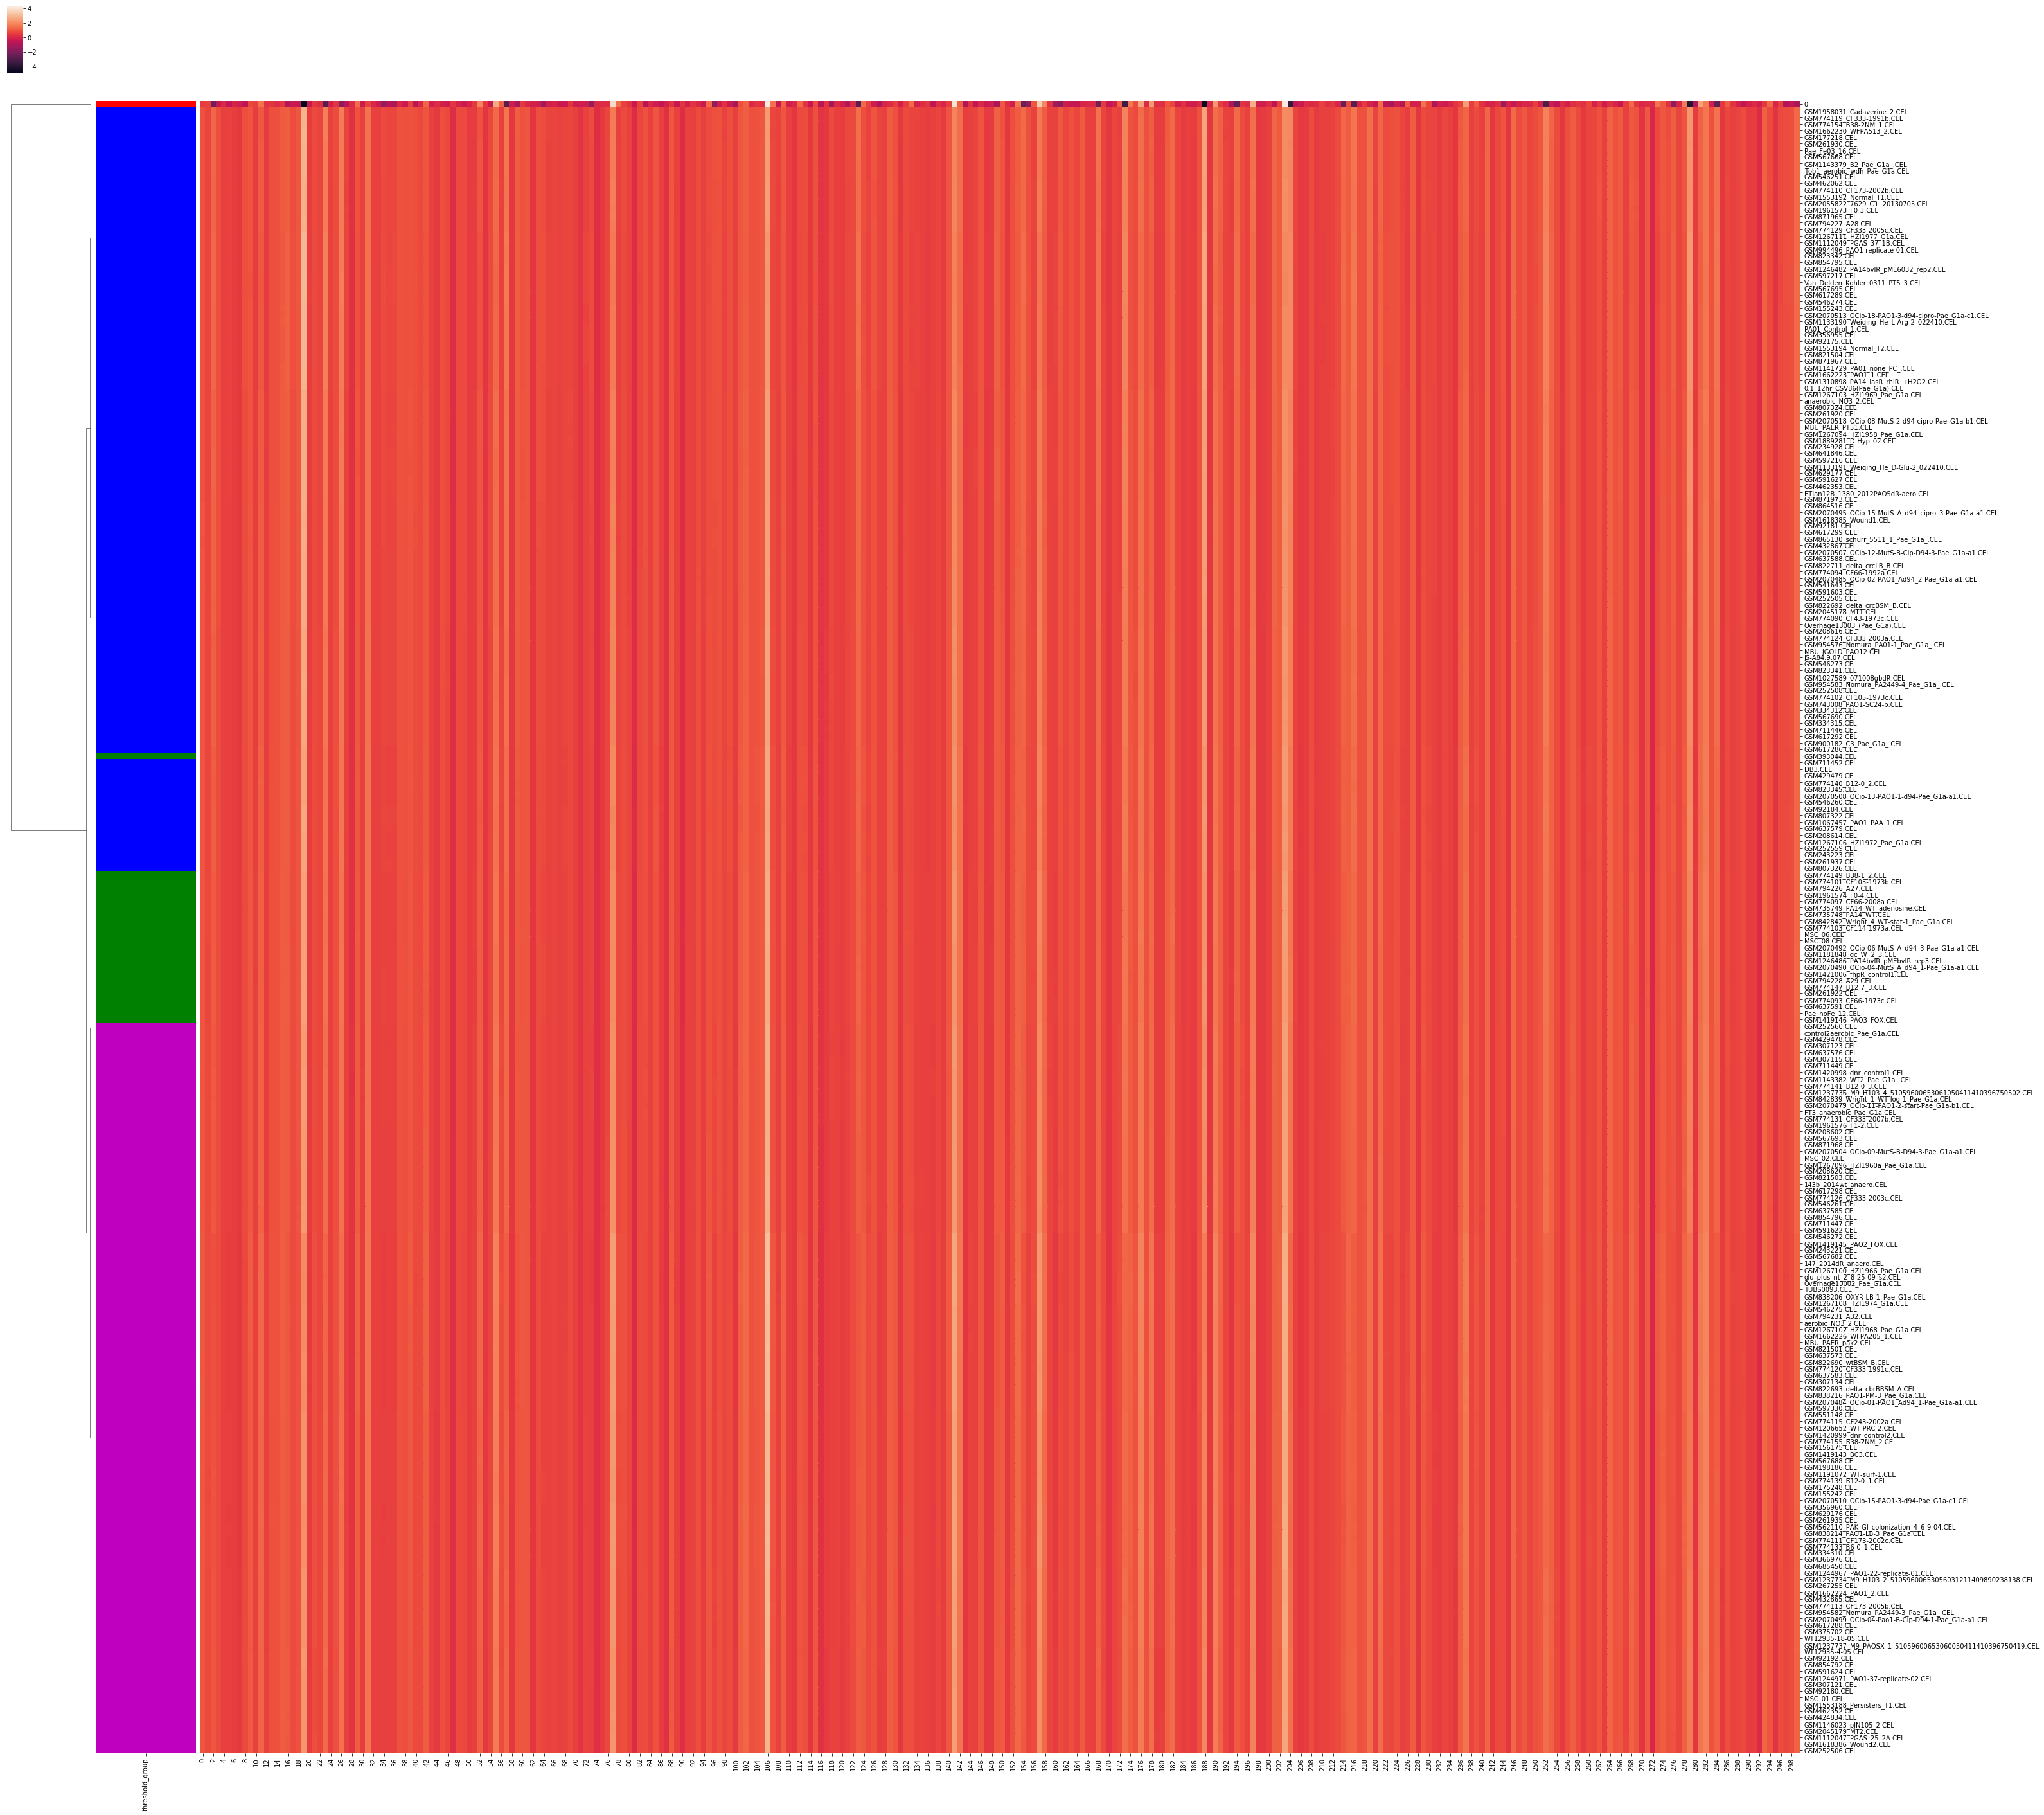

In [19]:
# Heatmap sorted by gene expression signature
# colormap: 
#     offset - red
#     less - blue
#     threshold - green
#     greater- magenta
threshold_groups = data_encoded_labeled["threshold_group"]
lut = dict(zip(threshold_groups.unique(), "rbgm"))
row_colors = threshold_groups.map(lut)

sns.clustermap(data_encoded,
               row_cluster=True,
               col_cluster=False,
               metric="correlation",
               row_colors=row_colors,
               figsize=(50,50))

### Collapse gene expression pattern
It is difficult to see any trends in large heatmap so collapse the encoded gene expression using mean per group

In [20]:
# Get mean of samples in each group ()

data_encoded_mean_less = pd.DataFrame(data_encoded_labeled[data_encoded_labeled.threshold_group == 'less'].mean(numeric_only=True))
data_encoded_mean_threshold = pd.DataFrame(data_encoded_labeled[data_encoded_labeled.threshold_group == 'threshold'].mean(numeric_only=True))
data_encoded_mean_greater = pd.DataFrame(data_encoded_labeled[data_encoded_labeled.threshold_group == 'greater'].mean(numeric_only=True))

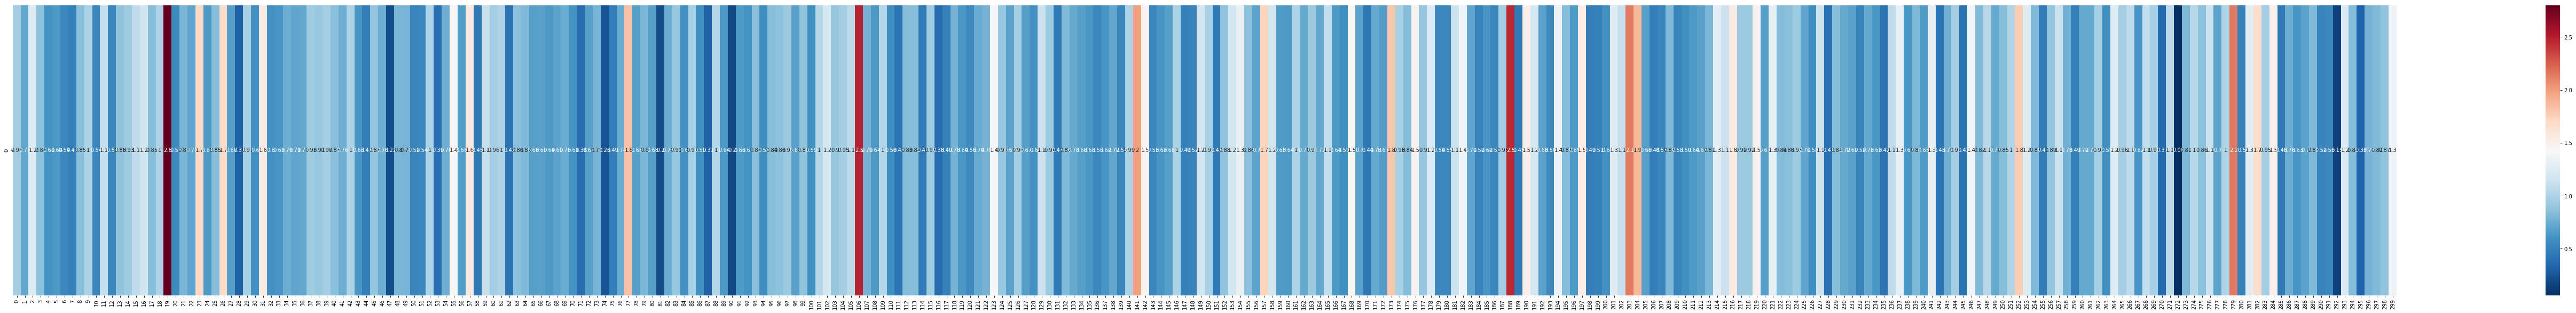

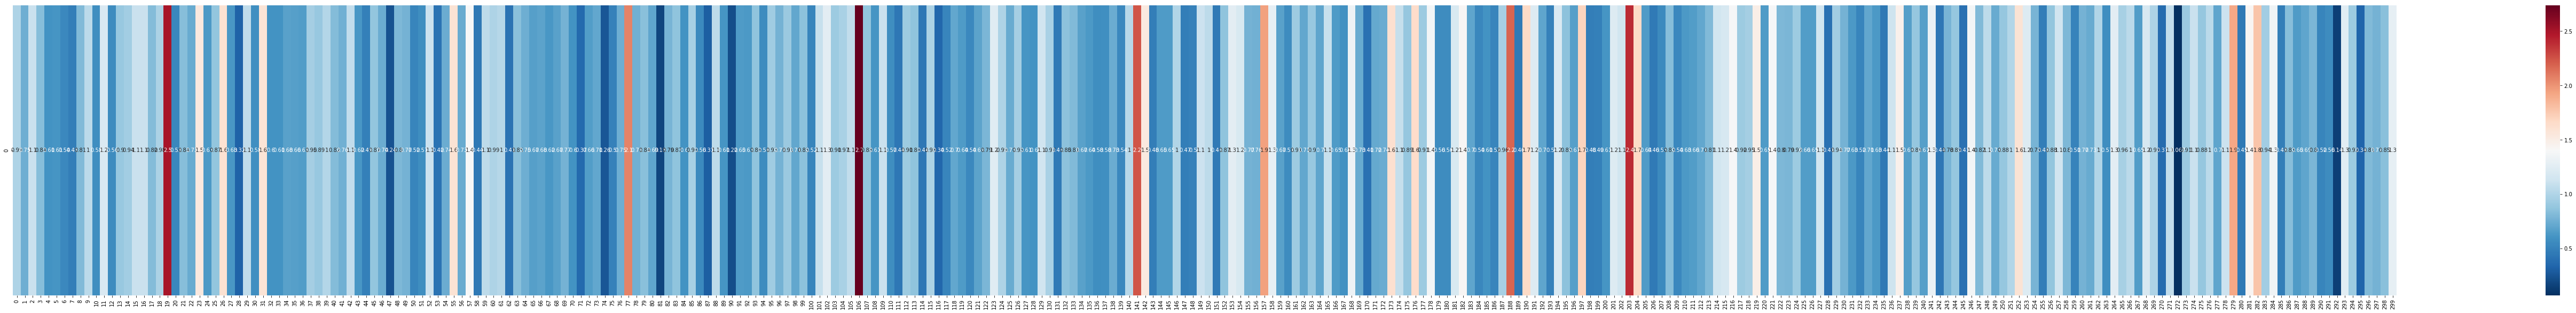

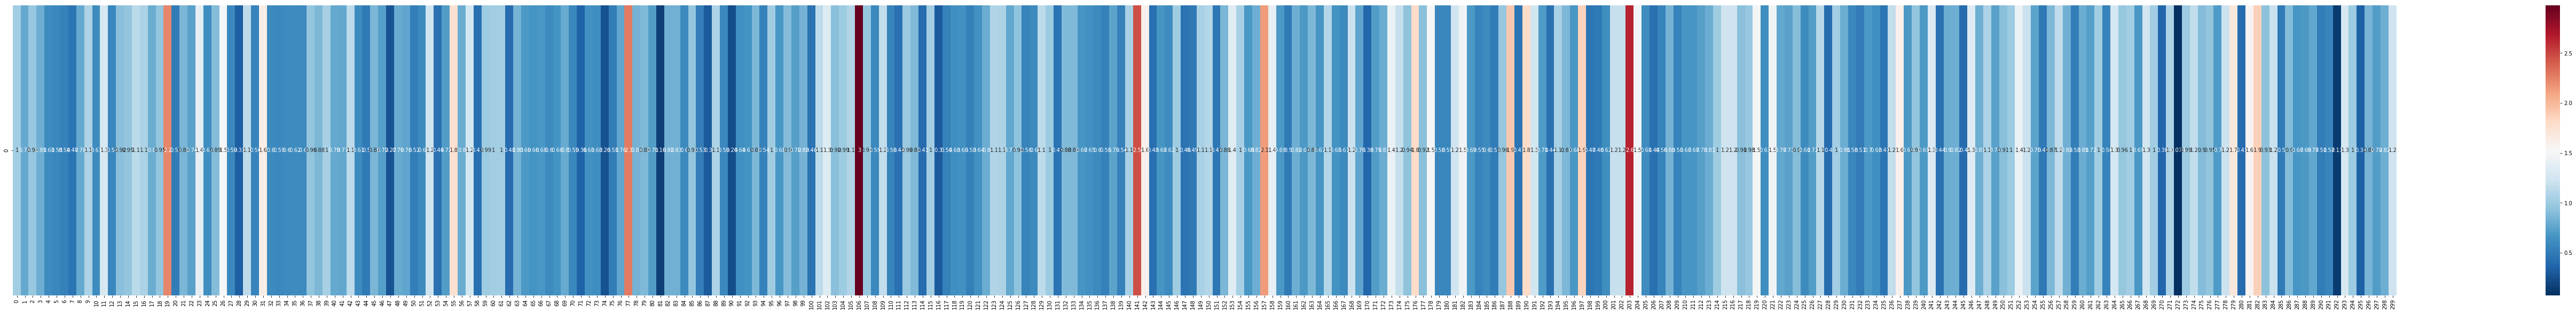

In [21]:
# Plot mean expression for each group
plt.figure(figsize=(100, 10))
sns.heatmap(data_encoded_mean_less.T, annot = True, cmap = "RdBu_r")
plt.figure(figsize=(100, 10))
sns.heatmap(data_encoded_mean_threshold.T, annot = True, cmap = "RdBu_r")
plt.figure(figsize=(100, 10))
sns.heatmap(data_encoded_mean_greater.T, annot = True, cmap = "RdBu_r")

### Which features have the largest difference as we cross the threshold?

In [22]:
# Difference in means
diff_data_encoded = data_encoded_mean_greater - data_encoded_mean_less
abs_diff_data_encoded = abs(diff_data_encoded)

# Get top 5 features
top_features = abs_diff_data_encoded[0].nlargest()
top_features

19     0.567658
188    0.539927
106    0.494475
203    0.491748
141    0.470725
Name: 0, dtype: float64

In [23]:
# Check sign of top features
feature_names = [int(l) for l in top_features.index]
diff_data_encoded.iloc[feature_names]

,0
19,-0.567658
188,-0.539927
106,0.494475
203,0.491748
141,0.470725


0    4.2243
Name: 106, dtype: float64


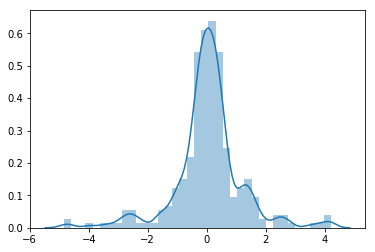

In [24]:
# What is the weight of the offset vector for this top feature?
top_feature = top_features.index[0]
print(offset_vae_space[top_feature])

sns.distplot(offset_vae_space)

## What is the trend of latent features across the threshold?

Plot trend of encoded values along threshold for top feature

In [25]:
# Join sorted original expression of A and encoded expression of top feature
original_A_exp = test_samples_sorted[rep_gene_A]
feature_values = data_encoded[top_feature]

trend_feature_df = pd.merge(original_A_exp.to_frame('gene A untransformed'),
                      feature_values.to_frame('values of feature {}'.format(top_feature)),
                      left_index=True, right_index=True)
trend_feature_df.head()

,gene A untransformed,values of feature 106
GSM597217.CEL,0.40005,2.284903
Van_Delden_Kohler_0311_PT5_3.CEL,0.40023,2.285711
GSM567695.CEL,0.40085,2.288496
GSM617289.CEL,0.40120,2.290068
GSM546274.CEL,0.40137,2.290831


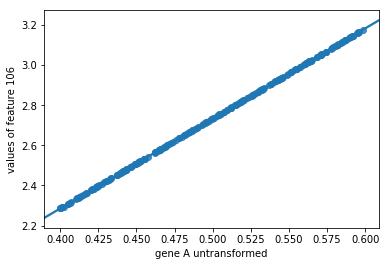

In [26]:
# Plot
sns.regplot(x='gene A untransformed',
            y='values of feature {}'.format(top_feature),
           data = trend_feature_df)

## Which genes are highly weighted in the feature of significance?

In [27]:
# Read in weight matrix
weight = pd.read_table(weight_file, header=0, index_col=0).T
weight.head(5)

,0,1,2,3,4,5,6,7,8,9,...,290,291,292,293,294,295,296,297,298,299
PA0001,-0.117849,-0.038603,0.025833,-0.017812,-0.038917,-0.025886,0.059616,-0.004224,0.061998,-0.104676,...,0.019363,0.007815,-0.052154,0.025949,0.021723,0.055437,-0.018286,0.016438,0.005548,-0.062284
PA0002,-0.475532,-0.376902,-0.292408,-0.443579,-0.275428,-0.237486,-0.131763,-0.309244,-0.123432,-0.239483,...,-0.337239,-0.167598,-0.673273,-0.215697,0.234006,-0.104485,-0.352983,-0.189724,-0.374923,-0.435261
PA0003,-0.028016,-0.147888,-0.118208,-0.176184,0.085006,-0.136751,-0.007269,-0.030653,-0.057265,-0.159458,...,0.029716,-0.110118,-0.190486,-0.035492,-0.083336,-0.039024,-0.120915,0.122573,-0.090189,-0.163588
PA0004,-0.008260,-0.027175,-0.036942,-0.081368,-0.004079,0.048033,-0.006661,0.012838,0.123765,-0.027641,...,0.028078,0.090266,0.021577,-0.017694,0.023099,-0.028170,0.063105,0.006962,0.101481,-0.073981
PA0005,0.056511,0.146070,0.111143,0.195392,0.008957,0.173715,0.095491,0.130729,-0.015219,0.029992,...,-0.012573,0.007769,-0.009655,0.074925,0.057350,0.033258,0.060091,0.037214,-0.054149,0.050110


In [28]:
# Get genes associated with top feature
top_feature = int(top_features.index[0])
top_feature_genes = weight[top_feature]

In [29]:
# Calculate mean per node ("signature" or "feature")
node_mean = top_feature_genes.mean()

# Calculate 2 standard deviations per node ("signature" or "feature")
stds = top_feature_genes.std()
two_stds = 2*stds

pos_threshold = node_mean + two_stds
neg_threshold = node_mean - two_stds
    
hw_pos_genes = top_feature_genes[top_feature_genes > pos_threshold].index
hw_neg_genes = top_feature_genes[top_feature_genes < neg_threshold].index

print(hw_pos_genes.shape)
hw_pos_genes

(25,)


Index(['PA0442', 'PA0465', 'PA0653', 'PA0716', 'PA0724', 'PA0725', 'PA1152',
       'PA1355', 'PA1369', 'PA1501', 'PA1723', 'PA1962', 'PA2226', 'PA2372',
       'PA2456', 'PA3057', 'PA3082', 'PA3432', 'PA3550', 'PA3762', 'PA3967',
       'PA4770', 'PA4834', 'PA4836', 'PA4987'],
      dtype='object')

In [30]:
print(hw_neg_genes.shape)
hw_neg_genes

(302,)


Index(['PA0002', 'PA0019', 'PA0029', 'PA0055', 'PA0066', 'PA0077', 'PA0083',
       'PA0084', 'PA0096', 'PA0106',
       ...
       'PA5346', 'PA5364', 'PA5460', 'PA5492', 'PA5505', 'PA5508', 'PA5552',
       'PA5554', 'PA5557', 'PA5558'],
      dtype='object', length=302)

In [31]:
# Convert dataframe with gene ids to list
geneSetA_ls = geneSetA['gene id'].values.tolist()
geneSetB_ls = geneSetB['gene id'].values.tolist()

geneSetA_set = set(geneSetA_ls)
geneSetB_set = set(geneSetB_ls)

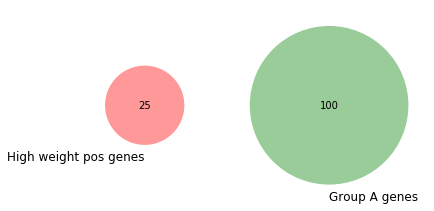

In [32]:
# Compare the overlap of genes in set A and highest positive weighted genes in top feature
venn2([set(hw_pos_genes), geneSetA_set], set_labels = ('High weight pos genes', 'Group A genes'))
plt.show()

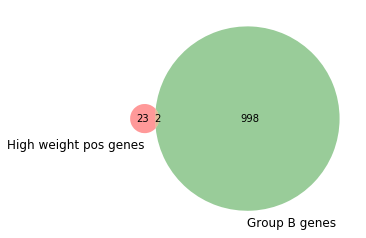

In [33]:
# Compare the overlap of genes in set B and highest positive weighted genes in top feature
venn2([set(hw_pos_genes), geneSetB_set], set_labels = ('High weight pos genes', 'Group B genes'))
plt.show()

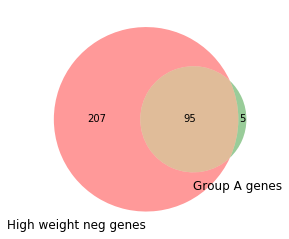

In [34]:
# Compare the overlap of genes in set A and highest negative weighted genes in top feature
venn2([set(hw_neg_genes), geneSetA_set], set_labels = ('High weight neg genes', 'Group A genes'))
plt.show()

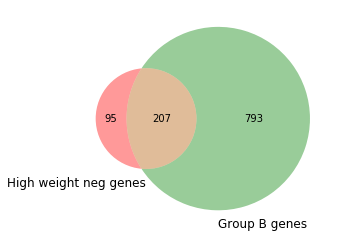

In [35]:
# Compare the overlap of genes in set B and highest negative weighted genes in top feature
venn2([set(hw_neg_genes), geneSetB_set], set_labels = ('High weight neg genes', 'Group B genes'))
plt.show()